In [1]:
# Initial Setup

train=True
Epochs=30
preload=False
hough=False
rams=False
dynAug=False
depth = 6
chan = 64
ir = 1.1
rand_sv = 42
ds = 'MIX'
zone = 'DISK'
cup = False
mix = True
dri = False
rim = False

In [2]:
# Import all the necessary libraries

import tensorflow as tf
import os
import glob
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, Lambda, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math

In [3]:
from tensorflow import keras

In [4]:
# Metrics for evaluation

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
def dice_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

# Computes mean Intersection-over-Union (IOU) for two arrays of binary images.

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [5]:
# helper function to increase the brightness
# hue, saturation, value

def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

In [6]:
def index512_resize(index,top):
    index=index*top/512
    return int(index)

In [7]:
# helper code to shuffle instead of random shuffle 

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
K.set_floatx('float32')

In [9]:
#load the data

h5f2 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), r'C:\Users\Ranjith ch\Desktop\code\glucoma\model\data', 'DRISHTI_GS.hdf5'), 'r')

In [10]:

Xori= np.asarray(h5f2['DRISHTI-GS/orig/images'])
disc_locations = np.asarray( h5f2['DRISHTI-GS/512 px/disc_locations'])
FC = np.asarray(h5f2['DRISHTI-GS/512 px/file_codes'] ) 
indDRI = np.arange(0,Xori.shape[0])
bsqside=np.maximum((disc_locations[:,3]-disc_locations[:,1]),(disc_locations[:,2]-disc_locations[:,0]))
isize=Xori.shape[1]

if (cup):
  
  Yf = np.asarray(h5f2['DRISHTI-GS/512 px/cup'])
 
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][0]+bsqside[i],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][1]+bsqside[i],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][0]+bsqside[i], disc_locations[i][1]:disc_locations[i][1]+bsqside[i]] 
                   for i in range(len(Xori))]

else:
  
  Yf =np.asarray( h5f2['DRISHTI-GS/512 px/disc'])
  
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

X=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym
#get binary mask
Yb=(Y>0.5).astype(np.float32) 

1.0 0.0


In [11]:
# step2: Create train and test set by combining datasets

rng = np.random.RandomState(rand_sv)

#DRISHTI
X_train1t, X_test1t, Y_train1t, Y_test1t, F_train1t, F_test1t ,ind_train1, ind_test1= train_test_split( X, Yb, FC, indDRI,test_size=0.25,random_state=rng)

X_test_dri=np.copy(X_test1t)
Y_test_dri=np.copy(Y_test1t)
F_test_dri=np.copy(F_test1t)


if(dri or mix):
  X_train1=np.concatenate([X_train1t,X_train1t])
  X_train1=np.concatenate([X_train1,X_train1t])
  X_test1=np.concatenate([X_test1t,X_test1t])
  X_test1=np.concatenate([X_test1,X_test1t])

  Y_train1=np.concatenate([Y_train1t,Y_train1t])
  Y_train1=np.concatenate([Y_train1,Y_train1t])
  Y_test1=np.concatenate([Y_test1t,Y_test1t])
  Y_test1=np.concatenate([Y_test1,Y_test1t])


if(dri):
  X_train1=np.concatenate([X_train1,X_train1])
  Y_train1=np.concatenate([Y_train1,Y_train1])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test1)
Y_test=np.asarray(Y_test1)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((20*size, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((20*size, 128, 128, 1),dtype=np.float32) 

In [12]:
# Step3: Preprocessing step for Cup Segmentation
# Perform CLAHE on each image

for i in range(16):
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.04)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.02)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((20*sizev, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((20*sizev, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.04)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.02)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [13]:
# step4: Shuffle the dataset

X_trains,Y_trains = unison_shuffled_copies(X_traine, Y_traine)
X_tests,Y_tests = unison_shuffled_copies(X_teste, Y_teste)

In [14]:
img_shape = 128

In [15]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [16]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_shape, img_shape, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [17]:

seed = rand_sv
batch_s = 120

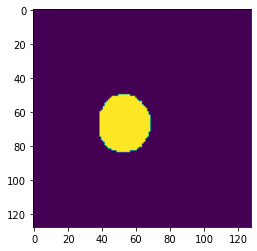

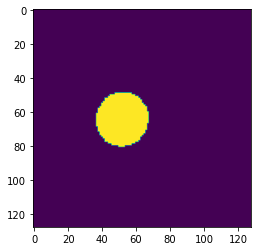

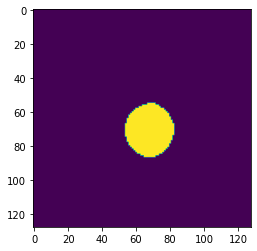

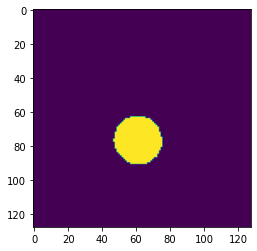

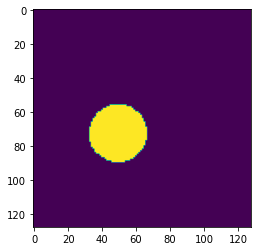

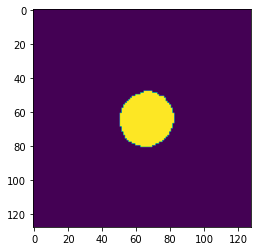

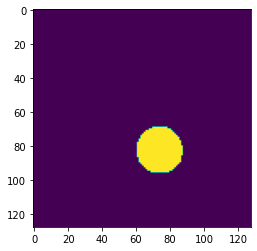

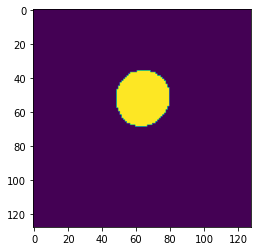

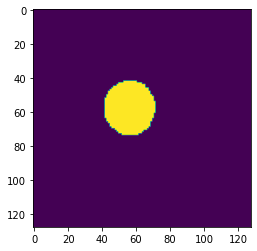

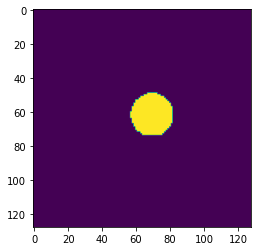

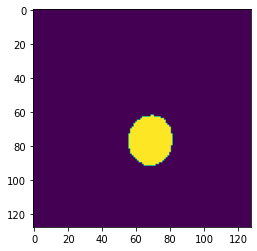

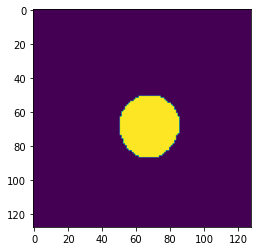

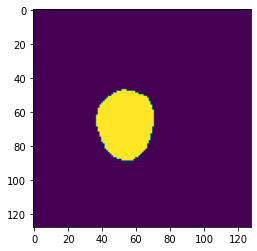

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(0, 14):
    plt.imshow(Y_teste[i])
    plt.figure(i+1)

In [18]:
# helper function for ipython notebook

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\res_disc_last_check_point.hdf5'), verbose=1, save_best_only=True,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=2e-4)

In [19]:
model = ResUNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001, ),
    loss=log_dice_loss, metrics=[dice_coef]
    )

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [23]:
# Model Training Step 

if(train):
    history = model.fit(
    X_trains,Y_trains,
    epochs=20,
    batch_size=128,
    steps_per_epoch=35,
    validation_data = (X_tests,Y_tests),
    callbacks=[cp_callbacks,reduce_lr],
    verbose=1
  )

# save the trained model weights
model.save_weights(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\res_disk_last_check_point.hdf5'), overwrite=True)

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.3566 - dice_coef: 0.7786 
Epoch 00001: val_loss improved from inf to 2.82354, saving model to C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\res_disc_last_check_point.hdf5
35/35 [==============================] - 774s 22s/step - loss: 0.3566 - dice_coef: 0.7786 - val_loss: 2.8235 - val_dice_coef: 0.0640 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.0387 - dice_coef: 0.9619 
Epoch 00002: val_loss improved from 2.82354 to 2.56397, saving model to C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\res_disc_last_check_point.hdf5
35/35 [==============================] - 739s 22s/step - loss: 0.0387 - dice_coef: 0.9619 - val_loss: 2.5640 - val_dice_coef: 0.0717 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.0263 - dice_coef: 0.9737 
Epoch 00003: val_loss did not improve from 2.56397
35/35 [==============================] - 751s 21s/step - loss: 0.0263 - dice_

In [24]:
result = model.evaluate(X_tests[0:700,:,:,:],Y_tests[0:700,:,:,:])
print("log dice loss for test set = ", result[0], ' ||| ',"dice coeffecient (accuracy) for test set = ", result[1])

22/22 [==============================] - 26s 985ms/step - loss: 0.1602 - dice_coef: 0.8525
log dice loss for test set =  0.1601698100566864  |||  dice coeffecient (accuracy) for test set =  0.8524940013885498


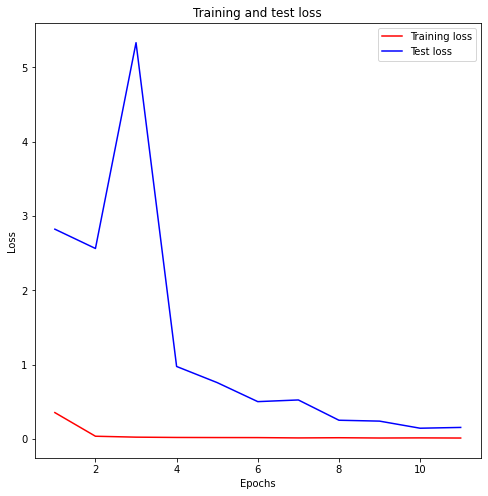

In [26]:

if(train):
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  acc=history.history['dice_coef']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','loss'+'model2_disk'+'.png'),dpi=600)

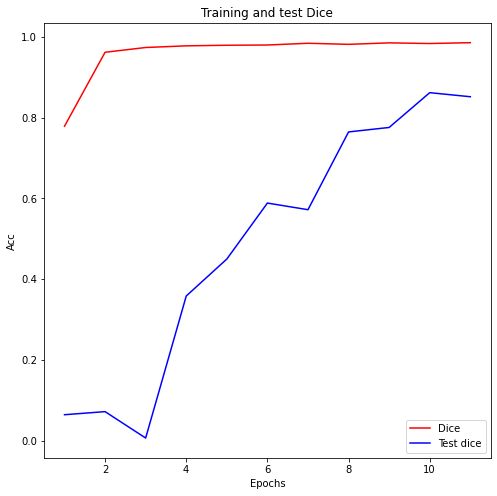

In [27]:
# plot train and test dice coeffecient (accuracy)
if(train):
  loss = history.history['loss']
  acc=history.history['dice_coef']
  val_acc=history.history['val_dice_coef']
  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, acc, 'r', label='Dice')
  plt.plot(epochs, val_acc, 'b', label='Test dice')
  plt.title('Training and test Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','hist'+'model2_disk'+'.png'),dpi=600)

In [28]:
# Defining metrics again

smooth=1e-07
def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )
    
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )   

In [29]:
# importing helper libraries for visualisation part

from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

In [30]:
test_s=int(X_test_dri.shape[0])
test_s

13

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

image #0
0.9066534


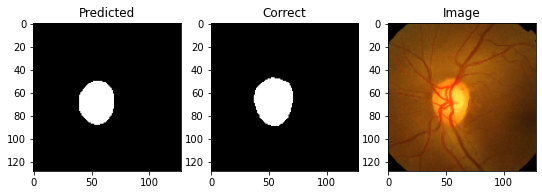

image #1
0.8728756


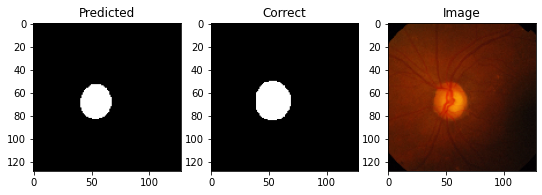

image #2
0.91906357


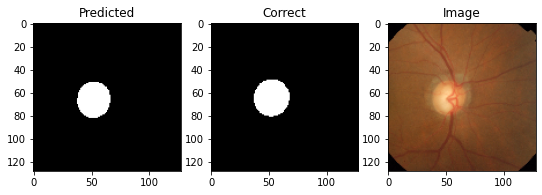

image #3
0.9054356


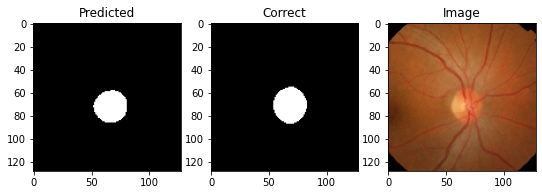

image #4
0.86071426


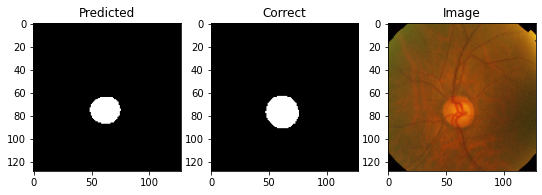

image #5
0.8598131


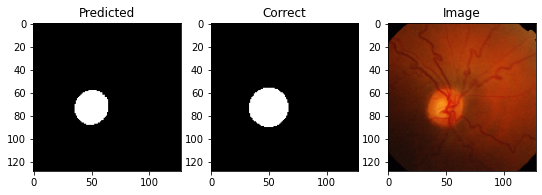

image #6
0.861324


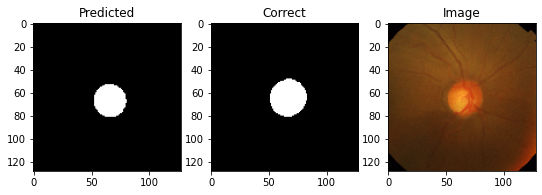

image #7
0.8104313


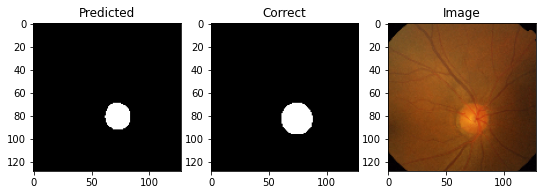

image #8
0.8579387


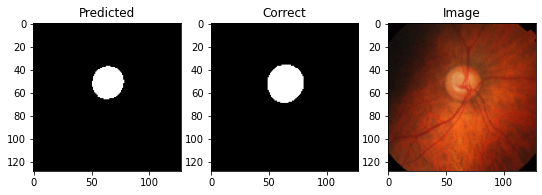

image #9
0.7031119


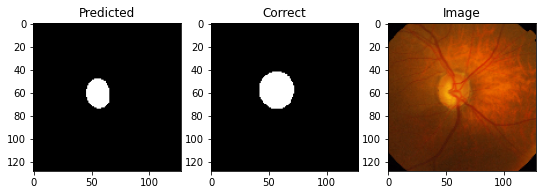

image #10
0.9324324


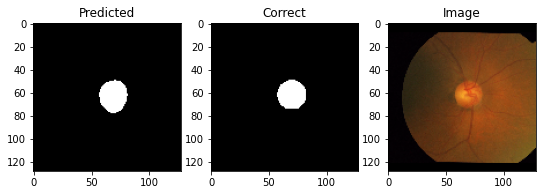

image #11
0.9234568


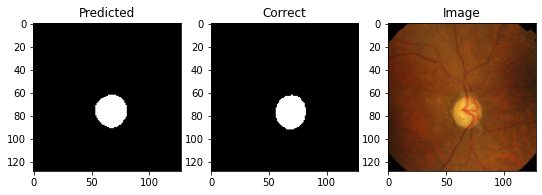

image #12
0.9227513


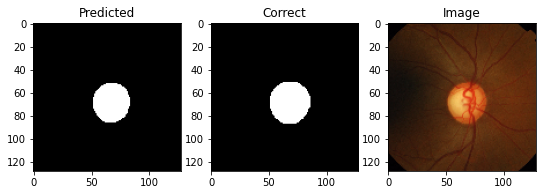

In [31]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    plt.show()
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.87200016  Std= 0.059686106  best= 0.9324324  worst= 0.7031119
IOU mean= 0.777661  Std= 0.08733896  best= 0.87341774  worst= 0.54215306
image #10
0.9324324
image #9
0.7031119


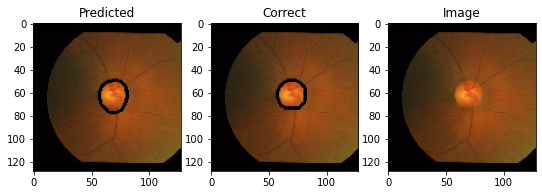

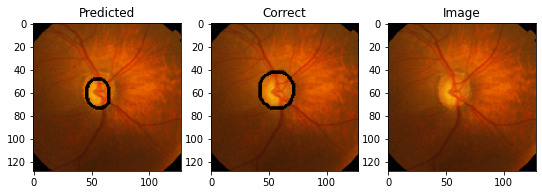

In [32]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    #fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model1_cup'+'.png'),dpi=600)
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.87200016  Std= 0.059686106  best= 0.9324324  worst= 0.7031119
IOU mean= 0.777661  Std= 0.08733896  best= 0.87341774  worst= 0.54215306
image #0
0.9066534
image #1
0.8728756
image #2
0.91906357
image #3
0.9054356
image #4
0.86071426
image #5
0.8598131
image #6
0.861324
image #7
0.8104313
image #8
0.8579387
image #9
0.7031119
image #10
0.9324324
image #11
0.9234568
image #12
0.9227513


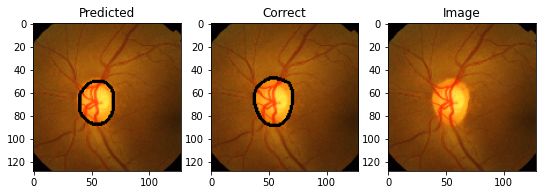

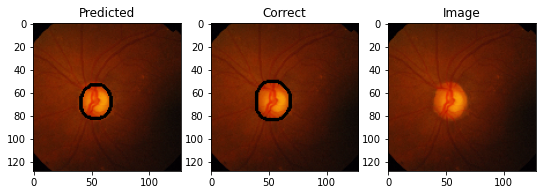

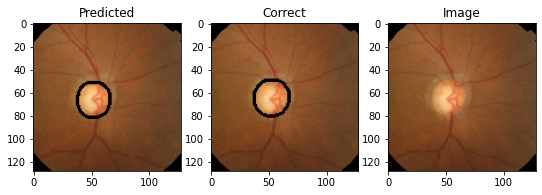

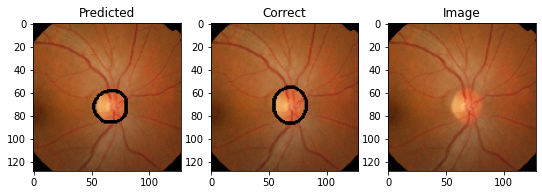

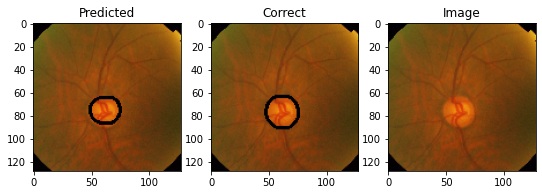

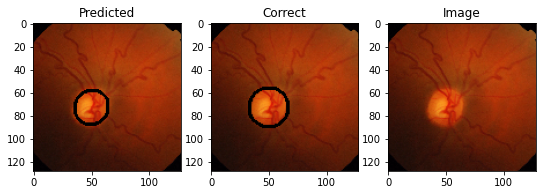

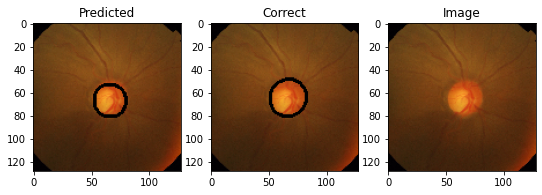

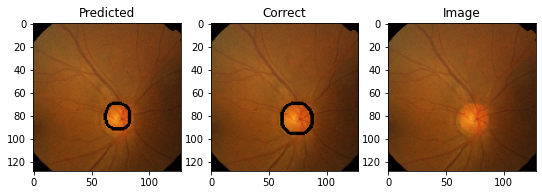

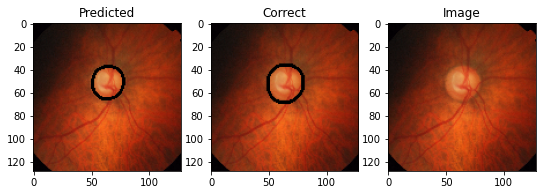

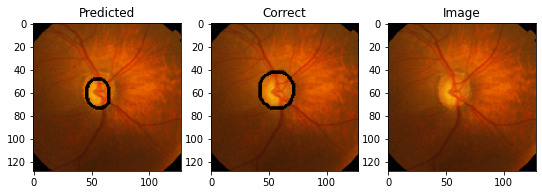

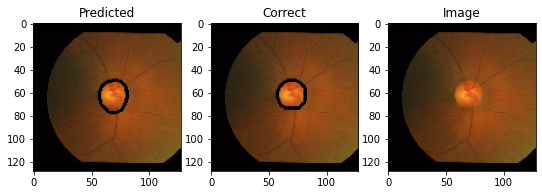

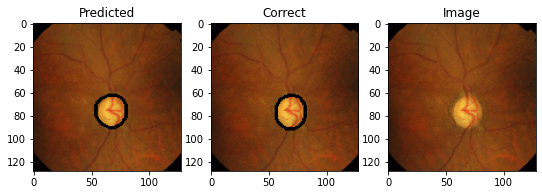

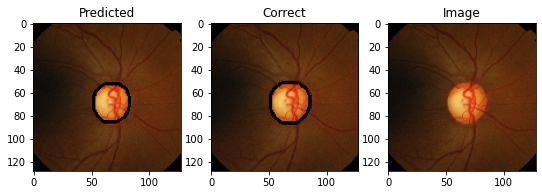

In [33]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model2_disc'+'.png'),dpi=600)
    j+=1